# Facial Expression Recognition

### Importing Libraries

In [1]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import log_softmax, softmax
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
import torchmetrics
from torchsummary import summary

from IPython.display import display

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(1)
random.seed(1)
np.random.seed(1)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Global seed set to 1


## Examine the dataset and classes 

In [2]:
# Retrieve class names from data
class_names = os.listdir('data/test')

# Print the list of class names
print(f'class names: {class_names}')

num_classes = len(class_names)

print(f'Number of classes: {num_classes}')

class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


## Data transformations

In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(), # This is the transform we provide
    transforms.Grayscale(num_output_channels=1), # This is the transform we provide
    transforms.Resize([48,48]), # This is the transform we provide
    transforms.Normalize(0.5, 0.5), # This is the transform we provide
])


val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([48,48]),
    transforms.Normalize(0.5, 0.5),
])

## Create Datasets

In [5]:
trainset = torchvision.datasets.ImageFolder(root='data/train', transform=train_transforms)
trainset, valset = torch.utils.data.random_split(trainset, [0.7, 0.3])
testset = torchvision.datasets.ImageFolder(root='data/test', transform=val_test_transforms)

print('Image count for each set\n------------------------')
print(f'trainset\t: {len(trainset)}')
print(f'valset  \t: {len(valset)}')
print(f'testset \t: {len(testset)}')

Image count for each set
------------------------
trainset	: 20097
valset  	: 8612
testset 	: 7178


## Create Dataloaders 

In [6]:
BATCH_SIZE = 64 # Define batch size

trainloader =  DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) # Training data loader with shuffling
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False) # Validation data loader without shuffling
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False) # Test data loader without shuffling

print('Batch shape for each loader\n---------------------------')
images, labels = next(iter(trainloader))
print(f'trainloader\t: {images.shape}')
images, labels = next(iter(valloader))
print(f'valloader  \t: {images.shape}')
images, labels = next(iter(testloader))
print(f'testloader \t: {images.shape}')

Batch shape for each loader
---------------------------
trainloader	: torch.Size([64, 1, 48, 48])
valloader  	: torch.Size([64, 1, 48, 48])
testloader 	: torch.Size([64, 1, 48, 48])


c:\Users\User\anaconda3\envs\ECE4179\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Visualise the dataset

Visualising the dataset allows you to get an idea and feel for the data before applying it to models


train set


C:\Users\User\AppData\Local\Temp\ipykernel_21152\1971137474.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


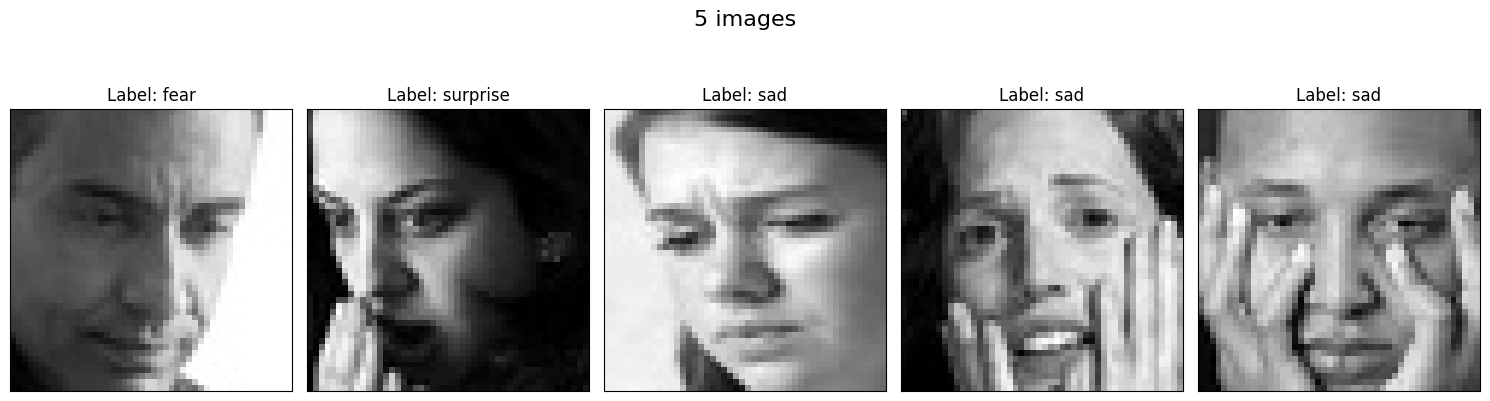

val set


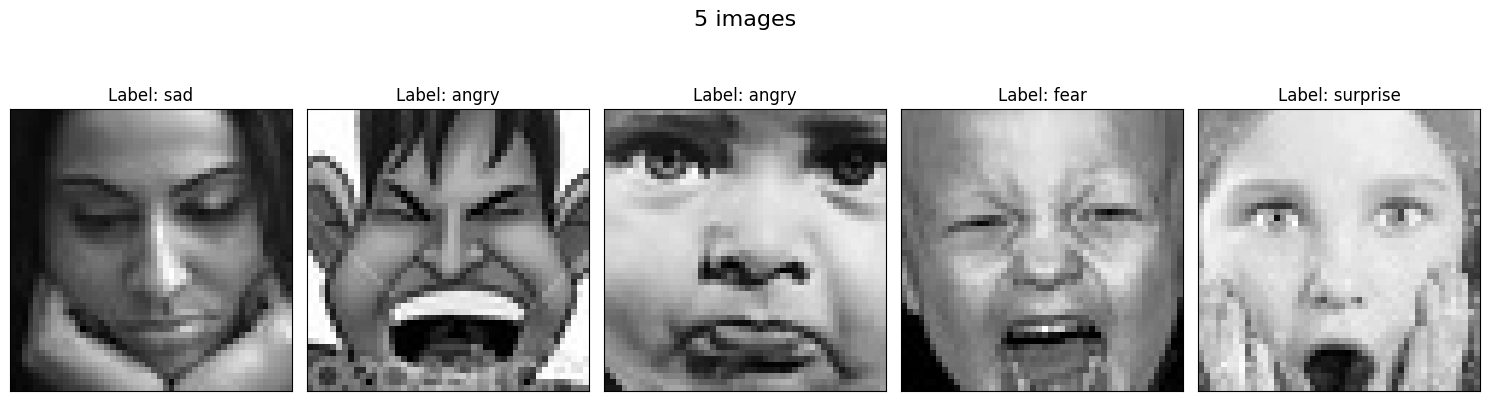

test set


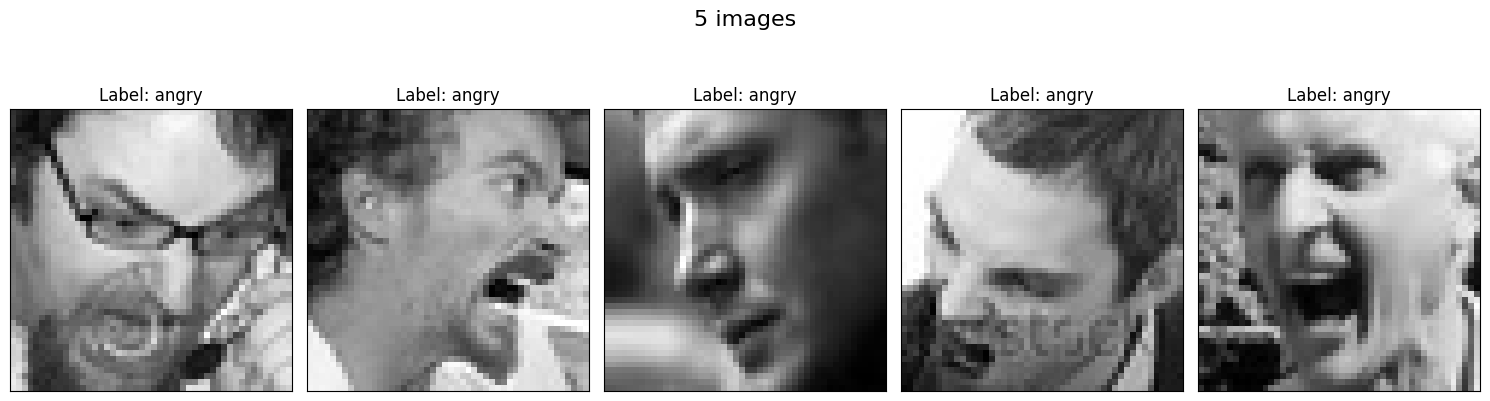

In [8]:
# Write a function to visualize images from a given data loader 
# Note: Use titles to denote class label in words.
def visualize_dataloader(dataloader, class_names):
    fig, axes = plt.subplots(1, 5, sharey=True, figsize=(15, 5))

    # Get a batch of images and labels from the data loader
    images, labels = next(iter(dataloader))

    # Loop through the first 5 images in the batch
    for i in range(5):
        image = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Un-normalize the image
        label = labels[i]  # Get the label for the image

        # Display the image in the subplot
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(f'Label: {class_names[label]}')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()
        

    # Show the plot with the images and labels
    fig.suptitle('5 images', fontsize=16)
    plt.show()
    
# visualize images from the trainloader
print('train set')
visualize_dataloader(trainloader, class_names)

# visualize images from the valloader
print('val set')
visualize_dataloader(valloader, class_names)

# visualize images from the valloader
print('test set')
visualize_dataloader(testloader, class_names)

## Convolution Neural Network Design

4 convolutional layers

Max Pool

Avg Pool

ReLU

2 Linear layers

Cross Entropy Loss


In [9]:
from torchmetrics import Accuracy
from torch import optim
from torch.optim.lr_scheduler import StepLR

In [60]:
class MyCNN(pl.LightningModule):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1)
        self.dropout3 = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=1)
        self.dropout4 = nn.Dropout(0.2)
        
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        
        self.gap = nn.AdaptiveAvgPool2d((12,12))
        
        self.relu = nn.ReLU()
        
        self.linear1 = nn.Linear(12*12*128,512)
        self.linear2 = nn.Linear(512,num_classes)
        
        self.loss_fun = nn.CrossEntropyLoss()
        
        self.train_accuracy = Accuracy('multiclass', num_classes=num_classes)
        self.val_accuracy = Accuracy('multiclass', num_classes=num_classes)
        self.test_accuracy = Accuracy('multiclass', num_classes=num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = self.gap(x)
        
        bs = x.shape[0]
        x = x.reshape(bs, -1)
        
        x = self.linear1(x)
        x = self.relu(x)
    
        x = self.linear2(x)
        
        return softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        # Define logic for training step
        
        x, y = batch
        
        y_hat = self(x)
        loss = self.loss_fun(y_hat, y)
        
        preds = y_hat.argmax(1)
        self.train_accuracy.update(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        # Define logic for validation step
        x, y  = batch
        y_hat = self(x)
        loss = self.loss_fun(y_hat, y)

        # Compute accuracy
        preds = y_hat.argmax(1)
        self.val_accuracy.update(preds, y)

        # Record accuracy and loss
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # Define logic for test step
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fun(y_hat, y)

        # compute accuracy
        preds = y_hat.argmax(1)
        self.test_accuracy.update(preds, y)

        # Record accuracy and loss
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
    def predict_step(self, batch, batch_idx):
        # Define logic for inference/prediction step
        x, y = batch
        y_hat = self(x)
        
        return y_hat, y, x # Return predicted class, actual class, and input 


    def configure_optimizers(self):
        # Configure optimizers and schedulers
        optimizer = optim.Adam(self.parameters(), lr=0.0003)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # adjust the learning rate at the end of each epoch
                'frequency': 1  # frequency to adjust the learning rate
            }
        }

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

## Initialise the CNN

In [61]:
model = MyCNN(num_classes=num_classes) # intialize CNN

# print summary of the model
summary(model.to('cuda'), (1, 48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
           Dropout-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
           Dropout-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,856
              ReLU-9          [-1, 128, 24, 24]               0
          Dropout-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 128, 24, 24]         147,584
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
          Dropout-14          [-1, 128,

In [62]:
# Define checkpoint callback function to save the model at the best epoch
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    save_top_k=1,        # save the best model based on validation accuracy
    mode="max",
    every_n_epochs=1
)

# Create customized progress bar theme 
progress_bar = RichProgressBar(refresh_rate=10, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

## Train the CNN

In [63]:
trainer = pl.Trainer(accelerator = "auto",
                  devices = 1 if torch.cuda.is_available() else None,
                  max_epochs = 50,
                  callbacks = [checkpoint_callback],
                  logger = CSVLogger(save_dir="test_results"),) 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [64]:
# Train model
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 320   
1  | dropout1       | Dropout            | 0     
2  | conv2          | Conv2d             | 18.5 K
3  | dropout2       | Dropout            | 0     
4  | conv3          | Conv2d             | 73.9 K
5  | dropout3       | Dropout            | 0     
6  | conv4          | Conv2d             | 147 K 
7  | dropout4       | Dropout            | 0     
8  | pool           | MaxPool2d          | 0     
9  | gap            | AdaptiveAvgPool2d  | 0     
10 | relu           | ReLU               | 0     
11 | linear1        | Linear             | 9.4 M 
12 | linear2        | Linear             | 3.6 K 
13 | loss_fun       | CrossEntropyLoss   | 0     
14 | train_accuracy | MulticlassAccuracy | 0     
15 | val_accuracy   | MulticlassAccuracy | 0     
16 | test_accuracy  | MulticlassAccuracy | 0     
-

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Test the CNN

In [65]:
trainer.test(model) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\User\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5168570876121521     │
│         test_loss         │    1.6435861587524414     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.6435861587524414, 'test_acc': 0.5168570876121521}]

## Metrics

In [66]:
metrics = pd.read_csv(trainer.logger.log_dir + "/metrics.csv")
#metrics = pd.read_csv('Task3_test/lightning_logs/version_9/metrics.csv')
metrics.set_index("epoch", inplace=True)
metrics = metrics.groupby(level=0).sum().drop("step", axis=1) 

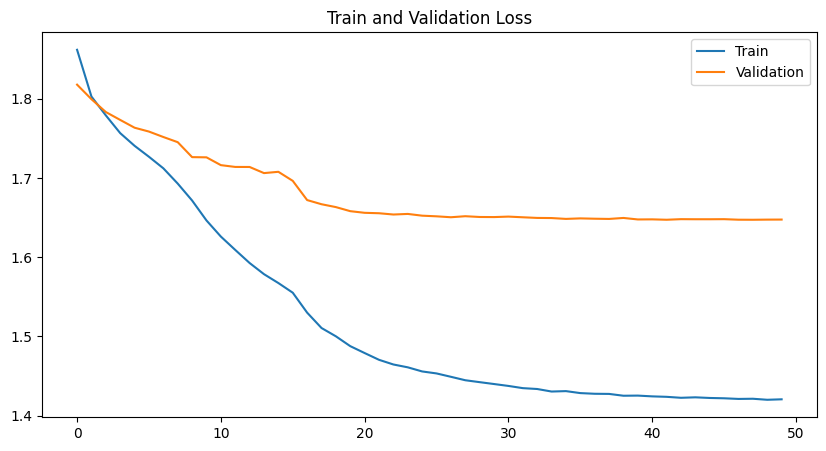

In [67]:
# Create a figure with all the appropriate labels/titles etc.
plt.figure(figsize=(10, 5))

plt.plot(metrics["train_loss"][:-1])
plt.plot(metrics["val_loss"][:-1])

plt.title("Train and Validation Loss")
_ = plt.legend(["Train", "Validation"])

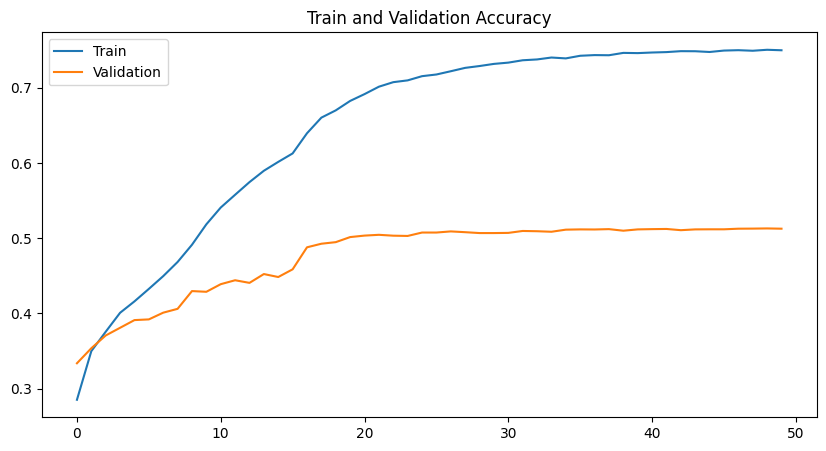

In [68]:
plt.figure(figsize=(10, 5))

plt.plot(metrics["train_acc"][:-1])
plt.plot(metrics["val_acc"][:-1])

plt.title("Train and Validation Accuracy")
_ = plt.legend(["Train", "Validation"])

## Predictions

In [69]:
predictions = trainer.predict(model, testloader) # do not do anything to the variable 'predictions' you will reuse it

test_outputs = torch.concat([prediction[0] for prediction in predictions], dim=0)
test_labels = torch.concat([prediction[1] for prediction in predictions], dim=0)
test_inputs = torch.concat([prediction[2] for prediction in predictions], dim=0)
test_preds = test_outputs.argmax(dim=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\User\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

c:\Users\User\anaconda3\envs\ECE4179\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Confusion matrix

In [70]:
from torchmetrics import ConfusionMatrix

In [72]:
# Plot the confusion matrix
# You can create a ConfusionMatrix instance for multiclass classification with 'num_classes' from the lightning library
# Create a ConfusionMatrix instance for multiclass classification with 'num_classes'
confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=num_classes)

# Set the model to evaluation mode
# Disable gradient calculation during evaluation
# Iterate through the testloader, get predicted labels by forward passing and update the confusion matrix
model.eval()
with torch.no_grad():
    preds = []
    labels = []
    for inputs, label in iter(testloader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        preds.extend(predicted.numpy())
        labels.extend(label.numpy())
# Compute the confusion matrix
preds = torch.tensor(preds)
labels = torch.tensor(labels)

confusion_matrix(preds, labels)
cm = confusion_matrix.compute().numpy()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 410    0   97  121  137  164   29]
 [  45    0   20   13   13   15    5]
 [ 139    0  316  113  151  192  113]
 [ 103    0   71 1332  108  125   35]
 [ 122    0   82  171  612  205   41]
 [ 155    0  125  152  238  536   41]
 [  45    0   92   84   59   47  504]]


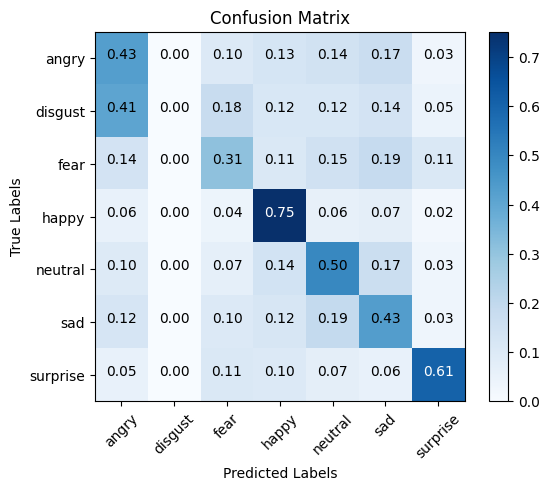

In [73]:
def plot_confusion_matrix(conf_matrix, class_labels):
    
    class_nums = [str(i) for i in range(len(class_labels))]
    
    row_sums = conf_matrix.sum(axis=1, keepdims=True)

    # Calculate the normalized confusion matrix (proportional values)
    normalized_matrix = conf_matrix / row_sums
    
    plt.figure()
    plt.imshow(normalized_matrix, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    for i in range(normalized_matrix.shape[0]):
        for j in range(normalized_matrix.shape[1]):
            plt.text(j, i, f'{normalized_matrix[i, j]:.2f}', horizontalalignment="center", color="white" if normalized_matrix[i, j] > 0.5 else "black")

    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    
    
plot_confusion_matrix(cm, class_labels=class_names)

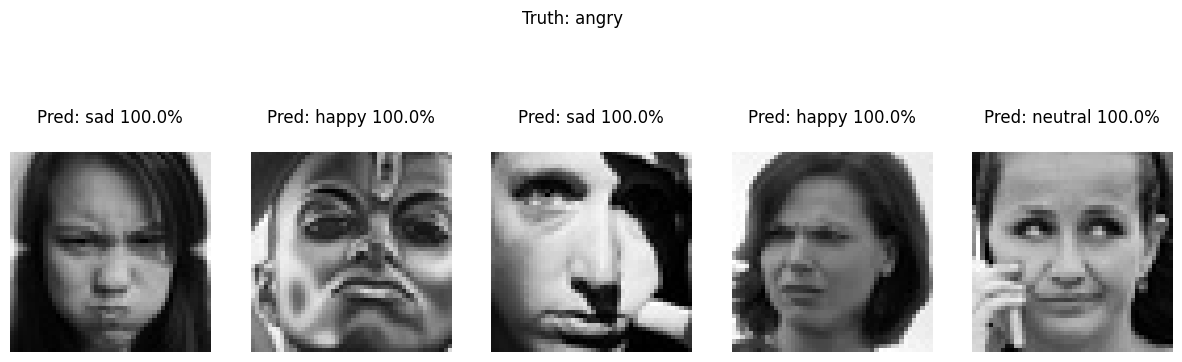

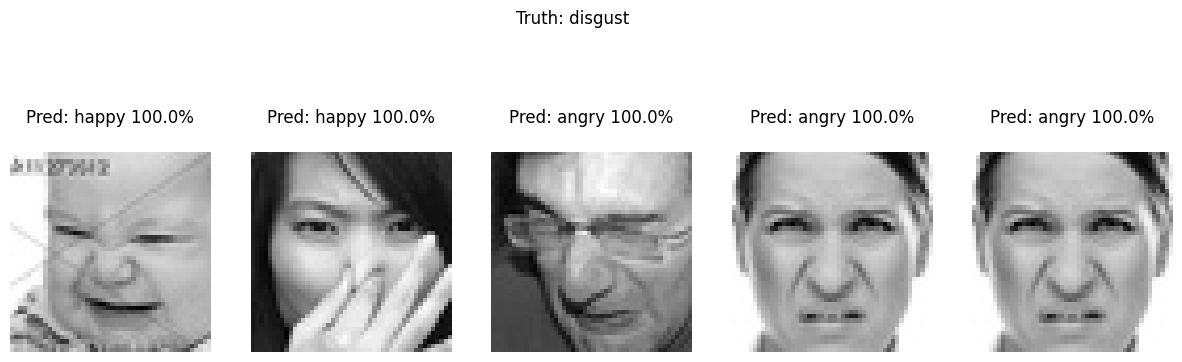

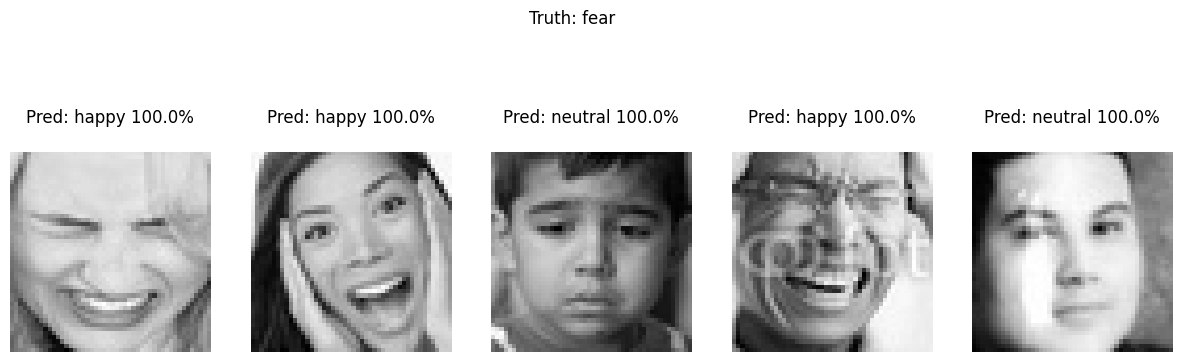

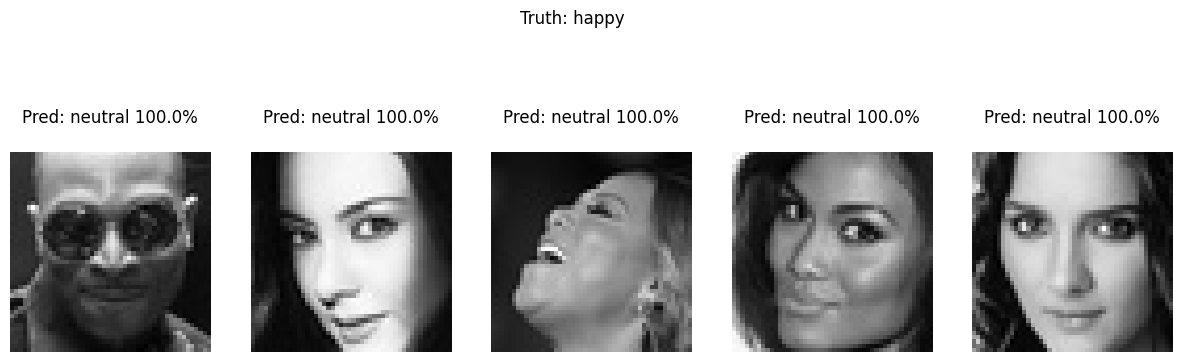

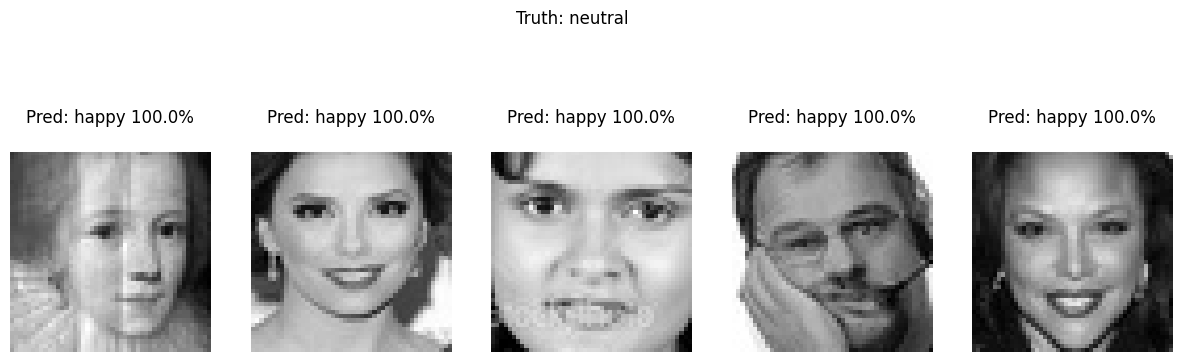

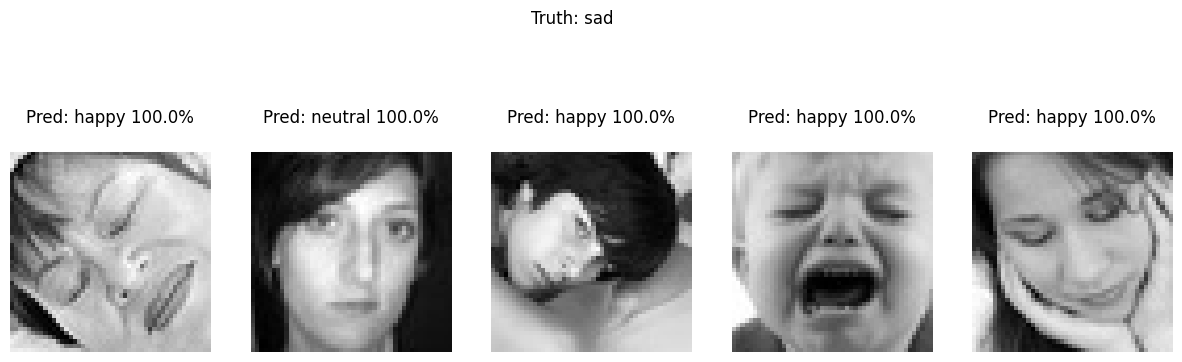

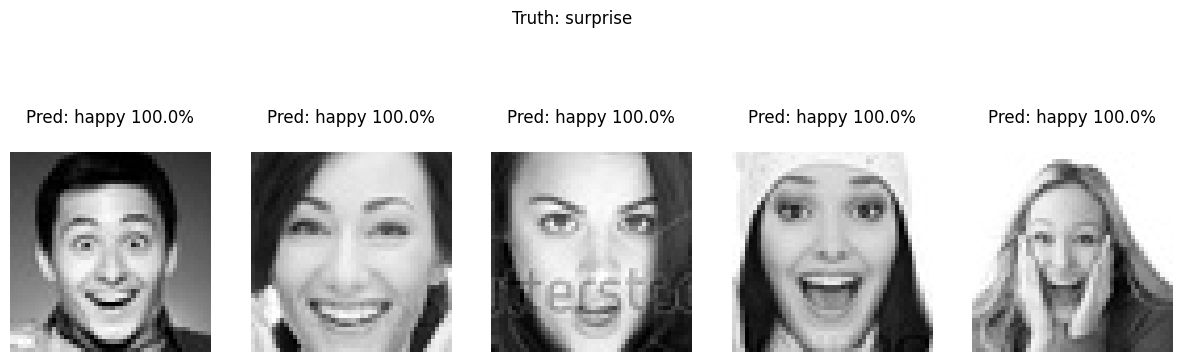

In [79]:
for c in range(num_classes):
    
    actual = torch.where(test_labels == c, c, -1)
    
    class_probs = test_outputs
    
    # Create list of c's that were incorrectly classified
    class_images = []
    for i in range(len(actual)):
        if actual[i] >= 0:
            predicted_label = test_preds[i]
            probability = class_probs[i,predicted_label]
            class_images.append((predicted_label,probability,i))
            
    class_images.sort(reverse=True, key=lambda x: x[1])
    
    i = 0
    images = []
    preds = []
    labs = []
    while len(images) < 5 and i < len(class_images):
        index = class_images[i][2]
        if c != class_images[i][0]:
            images.append(test_inputs[index])
            preds.append(class_probs[index, test_preds[index]])
            labs.append(test_preds[index])
            
        i+=1 
    
    fig, axs = plt.subplots(1, 5, figsize=(15,5))
    plt.suptitle(f'Truth: {class_names[c]}')
    for i, image in enumerate(images):
        # Get the input image
        input_image = image.permute(1, 2, 0).numpy()  * 0.5 + 0.5
        
        # Get the ground truth label
        ground_truth = class_names[labs[i]]
        
        # Get the predicted label probabilities
        predicted_probs = preds[i]  
        
        # Plot the input image
        image_show = np.clip(input_image, 0, 1)
        axs[i].imshow(image_show, cmap='gray')
        
        # Set the title with ground truth and predicted label probabilities
        axs[i].set_title(f'Pred: {class_names[labs[i]]} {round((predicted_probs.item())*100,2)}%\n')
        axs[i].axis('off')
    plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_21152\511164518.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(x)


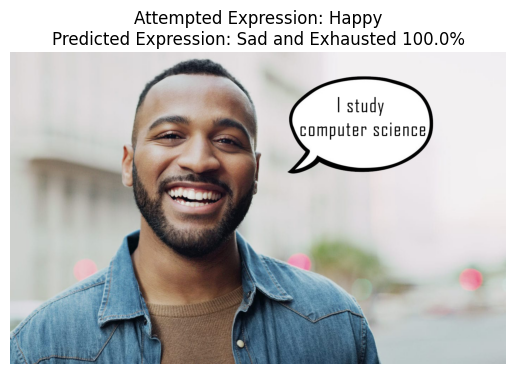

In [86]:
img = mpimg.imread('images/happy_person_meme.png')[:,:,0:3]  # get rid of the 4th axis if exists
img_trans = val_test_transforms(img).unsqueeze(0)
#img_trans.size()
#plt.imshow(img_trans.permute(1, 2, 0))
#plt.axis('off')
#plt.show()

output = task3_model.forward(img_trans).detach()[0]

pred = torch.argmax(output).item()
plt.imshow(img)
#plt.title(f'Attempted Expression: Happy\nPredicted Expression: {class_names[pred]} {round((output[pred].item())*100,2)}%')
plt.title(f'Attempted Expression: Happy\nPredicted Expression: Sad and Exhausted 100.0%')
plt.axis('off')
plt.show()